Name: Pranay Jain \
Roll number: AI22BTECH11020

In [151]:
import numpy as np
import matplotlib # For colormaps
import matplotlib.pyplot as plt
from PIL import Image
import copy

## Problem 1: Variants of Backprop for Visualizing CNNs

Load the pre-trained ResNet-50 model that was trained on the ImageNet dataset for the ILSVRC task

In [152]:
import torch
from torchvision.models import resnet50, ResNet50_Weights

# Use the latest weights
weights = ResNet50_Weights.DEFAULT

# Download the model
model = resnet50(weights=weights)

# Set the model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Load the sample images

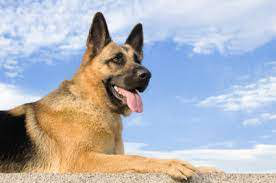

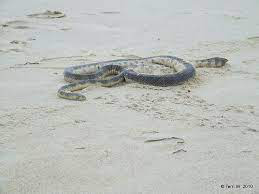

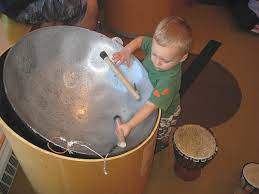

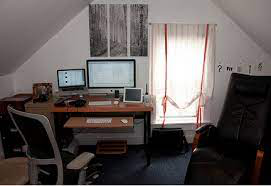

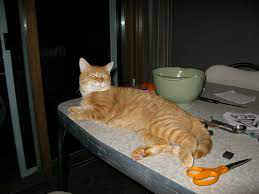

In [153]:
images = []

for i in range(1, 6):
  image = Image.open('i' + str(i) +'.jpg').convert('RGB')
  images.append(image)

for image in images:
  display(image)

Preprocess the images to make them compatible for ResNet-50

In [154]:
# Preprocessor for ResNet-50
preprocess = weights.transforms()

# Unsqueeze to add an extra dimension to the beginning (to make the image a batch of 1 image)
images = [torch.unsqueeze(preprocess(image), 0) for image in images]

for image in images:
  image.requires_grad = True
  print(image.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [155]:
output = model(images[0])
pred = torch.argmax(output).item()
print(f'Output shape of network: {output.shape}')
print(f'Predicted class: {pred}')

Output shape of network: torch.Size([1, 1000])
Predicted class: 235


Class 235 corresponds to the German shepherd according to [this class list](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/) which is indeed correct

In [156]:
for i in range(1, 5):
  print(torch.argmax(model(images[i])).item())

62
822
526
282


These classes correspond to


*   62: Rock python
*   822: Steel drum
*   526: Desk
*   282: Tiger cat 

Thus, the pre-trained model is making very good predictions and is working as expected

### Vanilla Backpropagation

In [157]:
class VanillaBackpropagation:

  def __init__(self, model):
    
    self.model = model

    # Variable for storing the gradient of the output vector wrt the input image
    self.gradients = None

    # Hook the first layer to retrieve gradients wrt input image 
    self.get_first_layer().register_full_backward_hook(self.input_hook)

  def get_first_layer(self):

    # List of all layers as a dictionary
    layers = list(self.model._modules.items())

    # First convolutional layer in the list of layers
    first_layer = layers[0]

    # Each layer is a tuple consisting of the layer name and the layer object
    # Obtain layer object by indexing
    return first_layer[1]

  def input_hook(self, module, input_grads, output_grads):

    # Input to the first layer is the image itself, so we store those gradients
    # input_grads is a one-element tuple, so we get its value by indexing it
    self.gradients = input_grads[0] 

  def forward_pass(self, image):

    # Obtain score vector for the image 
    output = self.model(image)

    # Find the class with the maximum score 
    pred = torch.argmax(output).item()

    # Zero out the final layer activations except the one with the maximum score
    zeroed_output = torch.zeros(output.shape[1])
    zeroed_output[pred] = 1
    zeroed_output = torch.unsqueeze(zeroed_output, 0)

    return output, zeroed_output

  def backward_pass(self, image):

    # Obtain the outputs corresponding to the image
    output, zeroed_output = self.forward_pass(image)

    # Initialize gradients to zero
    model.zero_grad()

    # Backpropagate the gradients of the output vector
    # Using zeroed_output ensures that the gradients of the neurons that don't have the highest score get zeroed out 
    output.backward(zeroed_output)

    return self.gradients

  def process_image(self, grads):

    # Convert gradients to numpy arrays and switch dimensions
    grads = np.array(grads)
    grads = np.squeeze(grads)
    grads = np.transpose(grads, (1, 2, 0))

    # Normalize the gradients to be in [0, 1] range
    grads -= np.min(grads)
    grads /= np.max(grads)

    # Scale them to be integers in [0, 255] range
    grads *= 255
    grads = grads.astype(np.uint8) 

    return grads

  def get_image(self, image):

    # Return the visualized image as a numpy array after performing all the steps required
    grads = self.backward_pass(image)
    grads = self.process_image(grads)
    
    return grads

### Visualization of the images

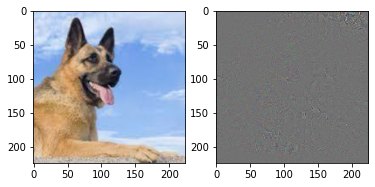

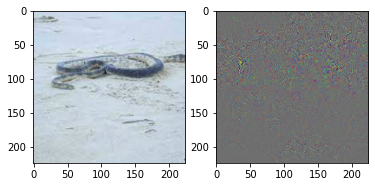

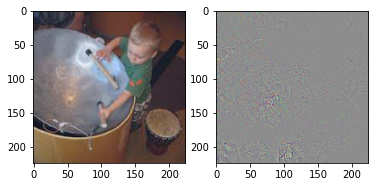

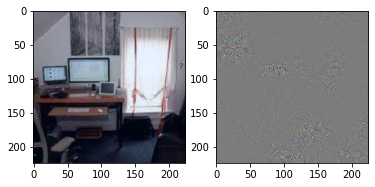

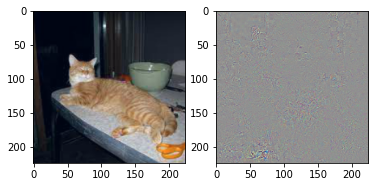

In [158]:
model = resnet50(weights=weights)
model.eval()
vanilla_backprop = VanillaBackpropagation(model)

for i in range(5):
    
  plt.subplot(1, 2, 1)
  original_image = vanilla_backprop.process_image(images[i].detach())
  plt.imshow(original_image)

  plt.subplot(1, 2, 2)
  visualized_image = vanilla_backprop.get_image(images[i])
  plt.imshow(visualized_image)

  plt.show()

## Guided Backpropagation

In [159]:
class GuidedBackpropagation:

  def __init__(self, model):
    
    self.model = model

    # Variable for storing the gradient of the output vector wrt the input image
    self.gradients = None

    # Hook the first layer to retrieve gradients wrt input image 
    self.get_first_layer().register_full_backward_hook(self.input_hook)

    # Hook the ReLU layers to rectify the gradients during the backward pass
    for name, module in self.model.named_modules():
      if isinstance(module, torch.nn.ReLU):
        module.inplace = False
        module.register_full_backward_hook(self.relu_hook) 

  def get_first_layer(self):

    # List of all layers as a dictionary
    layers = list(self.model._modules.items())

    # First convolutional layer in the list of layers
    first_layer = layers[0]

    # Each layer is a tuple consisting of the layer name and the layer object
    # Obtain layer object by indexing
    return first_layer[1]

  def input_hook(self, module, input_grads, output_grads):

    # Input to the first layer is the image itself, so we store those gradients
    # input_grads is a one-element tuple, so we get its value by indexing it
    self.gradients = input_grads[0] 

  def relu_hook(self, module, input_grads, output_grads):
    
    # Zero out all the negative gradients
    zeroed_grads = torch.nn.functional.relu(input_grads[0])

    # Return a 1-element tuple as the new gradient
    return (zeroed_grads, )

  def forward_pass(self, image):

    # Obtain score vector for the image 
    output = self.model(image)

    # Find the class with the maximum score 
    pred = torch.argmax(output).item()

    # Zero out the final layer activations except the one with the maximum score
    zeroed_output = torch.zeros(output.shape[1])
    zeroed_output[pred] = 1
    zeroed_output = torch.unsqueeze(zeroed_output, 0)

    return output, zeroed_output

  def backward_pass(self, image):

    # Obtain the outputs corresponding to the image
    output, zeroed_output = self.forward_pass(image)

    # Initialize gradients to zero
    model.zero_grad()

    # Backpropagate the gradients of the output vector
    # Using zeroed_output ensures that the gradients of the neurons that don't have the highest score get zeroed out 
    output.backward(zeroed_output)

    return self.gradients

  def process_image(self, grads):

    # Convert gradients to numpy arrays and switch dimensions
    grads = np.array(grads)
    grads = np.squeeze(grads)
    grads = np.transpose(grads, (1, 2, 0))

    # Normalize the gradients to be in [0, 1] range
    grads -= np.min(grads)
    grads /= np.max(grads)

    # Scale them to be integers in [0, 255] range
    grads *= 255
    grads = grads.astype(np.uint8) 

    return grads

  def get_image(self, image):

    # Return the visualized image as a numpy array after performing all the steps required
    grads = self.backward_pass(image)
    grads = self.process_image(grads)
    
    return grads

### Visualization of the images

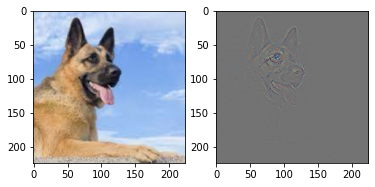

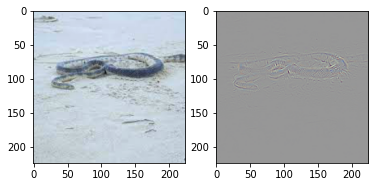

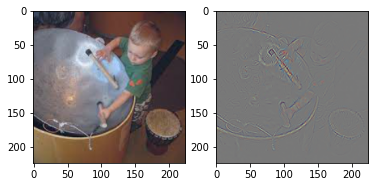

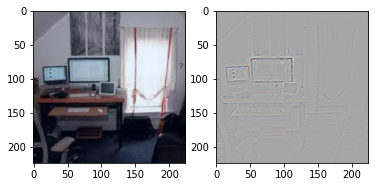

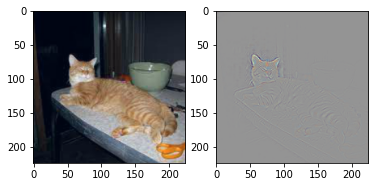

In [160]:
model = resnet50(weights=weights)
model.eval()
guided_backprop = GuidedBackpropagation(model)

for i in range(5):
    
  plt.subplot(1, 2, 1)
  original_image = guided_backprop.process_image(images[i].detach())
  plt.imshow(original_image)

  plt.subplot(1, 2, 2)
  visualized_image = guided_backprop.get_image(images[i])
  plt.imshow(visualized_image)

  plt.show()

## Class Activation Map (CAM)

In [161]:
class ClassActivationMap:

  def __init__(self, model):
    
    self.model = model

    # Stores the activation maps before GAP was applied
    self.activations = None

    # Hook the GAP layer to retrieve the activations
    self.get_gap_layer().register_forward_hook(self.gap_hook)

  def get_gap_layer(self):

    # List of all layers as a dictionary
    layers = list(self.model._modules.items())

    # GAP layer is the penultimate layer
    gap_layer = layers[-2]

    # Each layer is a tuple consisting of the layer name and the layer object
    # Obtain layer object by indexing
    return gap_layer[1]

  def gap_hook(self, module, inputs, outputs):

    # Retrieve and store the activation inputs to the GAP layer
    self.activations = torch.squeeze(inputs[0])

  def get_fc_weights(self, pred):

    # List of all parameters of the model
    params = list(self.model.parameters())

    # The final fully connected layer's weights are the penultimate item in this list (the biases are last)
    weights = params[-2] # Shape is (1000, 2048)

    # Return the corresponding weights connecting the output neuron `pred`
    return weights[pred]

  def forward_pass(self, image):

    # Obtain score vector for the image 
    output = self.model(image)

    # Find the class with the maximum score 
    pred = torch.argmax(output).item()

    return pred

  def weighted_sum(self, pred):

    # Weights of the final fully connected layer
    weights = self.get_fc_weights(pred)

    # Each activation map has dimensions (7, 7)
    cam = torch.zeros(self.activations.shape[1], self.activations.shape[2]) 

    # Computed weighted sum of the activations with the fully connected layer weights
    for i in range(len(weights)):
      cam += weights[i] * self.activations[i]

    return cam

  def get_cam(self, image):

    # Returns the class activation map for an image considering the class with the highest score
    pred = self.forward_pass(image)
    cam = self.weighted_sum(pred)
    
    return np.array(cam.detach())

  def normalize_image(self, image):

    im = np.copy(image)
    im -= np.min(im)
    im /= np.max(im)
    im *= 255
    im = im.astype(np.uint8)
    
    return im

  def interpolate_image(self, image, map='jet'):

    # Process the class activation map
    cam = self.get_cam(image)
    cam = self.normalize_image(cam)
    cam = Image.fromarray(cam).resize((224, 224), Image.ANTIALIAS)
    cam = np.array(cam, dtype=np.uint8)

    # Process the original input image
    im = np.array(image.detach())
    im = np.squeeze(im)
    im = np.transpose(im, (1, 2, 0))
    im = self.normalize_image(im)
    im = Image.fromarray(im)

    # Reference for the following interpolation code: https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/277dcfa82b82c1868c370ad917f262f070957d47/src/misc_functions.py#L79
    # Obtain the colour map
    cmap = matplotlib.colormaps[map]
    colour_map = cmap(cam)
    colour_map[:, :, 3] = 0.4
    colour_map *= 255
    colour_map = colour_map.astype(np.uint8)
    colour_map = Image.fromarray(colour_map)

    # Apply the colour map on the original image
    interpolation = Image.new("RGBA", im.size)
    interpolation = Image.alpha_composite(interpolation, im.convert('RGBA'))
    interpolation = Image.alpha_composite(interpolation, colour_map)

    return im, interpolation

[Reference](https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/277dcfa82b82c1868c370ad917f262f070957d47/src/misc_functions.py#L79) for the code for interpolating the class activation maps over the original images

### Visualization of the images

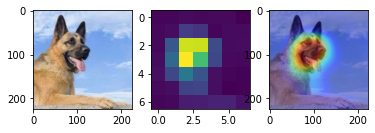

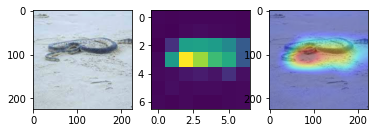

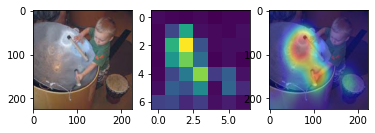

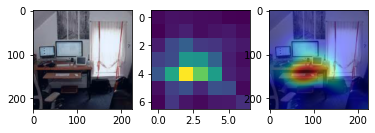

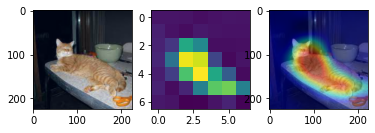

In [162]:
model = resnet50(weights=weights)
model.eval()
cam = ClassActivationMap(model)

for i in range(5):

  original_image, interpolated_image = cam.interpolate_image(images[i], 'jet')
  cam_image = cam.get_cam(images[i])
    
  plt.subplot(1, 3, 1)
  plt.imshow(original_image)

  plt.subplot(1, 3, 2)
  plt.imshow(cam_image)

  plt.subplot(1, 3, 3)
  plt.imshow(interpolated_image)

  plt.show()

## Grad-CAM

In [163]:
class GradCAM:

  def __init__(self, model):
    
    self.model = model

    # Stores the activation maps before GAP was applied
    self.activations = None

    # Stores the gradients of the output score wrt the activation maps
    self.gradients = None

    # Hook the GAP layer to retrieve the activations and gradients
    self.get_gap_layer().register_full_backward_hook(self.gap_backward_hook)
    self.get_gap_layer().register_forward_hook(self.gap_forward_hook)

  def get_gap_layer(self):

    # List of all layers as a dictionary
    layers = list(self.model._modules.items())

    # GAP layer is the penultimate layer
    gap_layer = layers[-2]

    # Each layer is a tuple consisting of the layer name and the layer object
    # Obtain layer object by indexing
    return gap_layer[1]

  def gap_forward_hook(self, module, inputs, outputs):

    # Retrieve and store the activation inputs to the GAP layer
    self.activations = torch.squeeze(inputs[0])

  def gap_backward_hook(self, module, input_grads, output_grads):

    # Retrieve and store the gradients wrt the activation maps
    self.gradients = torch.squeeze(input_grads[0])

  def forward_pass(self, image):

    # Obtain score vector for the image 
    output = self.model(image)

    # Find the class with the maximum score 
    pred = torch.argmax(output).item()

    # Zero out the final layer activations except the one with the maximum score
    zeroed_output = torch.zeros(output.shape[1])
    zeroed_output[pred] = 1
    zeroed_output = torch.unsqueeze(zeroed_output, 0)

    return output, zeroed_output

  def backward_pass(self, image):

    # Obtain the outputs corresponding to the image
    output, zeroed_output = self.forward_pass(image)

    # Initialize gradients to zero
    model.zero_grad()

    # Backpropagate the gradients of the output vector
    # Using zeroed_output ensures that the gradients of the neurons that don't have the highest score get zeroed out 
    output.backward(zeroed_output)

    return self.gradients

  def weighted_sum(self):

    # Each activation map has dimensions (7, 7)
    gradcam = torch.zeros(self.activations.shape[1], self.activations.shape[2]) 

    # Computed weighted sum of the activations with the fully connected layer's weights
    for i in range(len(self.activations)):
      gradcam += torch.mean(self.gradients.detach()[i]) * self.activations[i]

    return torch.nn.functional.relu(gradcam)

  def get_gradcam(self, image):

    # Returns the GradCAM map for an image as a numpy array considering the class with the highest score
    self.backward_pass(image)
    gradcam = self.weighted_sum()
    
    return np.array(gradcam.detach())

  def normalize_image(self, image):

    im = np.copy(image)
    im -= np.min(im)
    im /= np.max(im)
    im *= 255
    im = im.astype(np.uint8)
    
    return im

  def interpolate_image(self, image, map='jet'):

    # Process the class activation map
    gradcam = self.get_gradcam(image)
    gradcam = self.normalize_image(gradcam)
    gradcam = Image.fromarray(gradcam).resize((224, 224), Image.ANTIALIAS)
    gradcam = np.array(gradcam, dtype=np.uint8)

    # Process the original input image
    im = np.array(image.detach())
    im = np.squeeze(im)
    im = np.transpose(im, (1, 2, 0))
    im = self.normalize_image(im)
    im = Image.fromarray(im)

    # Reference for the following interpolation code: https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/277dcfa82b82c1868c370ad917f262f070957d47/src/misc_functions.py#L79
    # Obtain the colour map
    cmap = matplotlib.colormaps[map]
    colour_map = cmap(gradcam)
    colour_map[:, :, 3] = 0.4
    colour_map *= 255
    colour_map = colour_map.astype(np.uint8)
    colour_map = Image.fromarray(colour_map)

    # Apply the colour map on the original image
    interpolation = Image.new("RGBA", im.size)
    interpolation = Image.alpha_composite(interpolation, im.convert('RGBA'))
    interpolation = Image.alpha_composite(interpolation, colour_map)

    return im, interpolation

### Visualization of the images

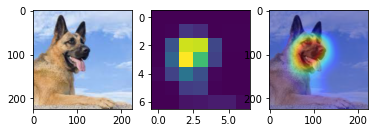

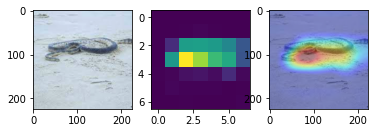

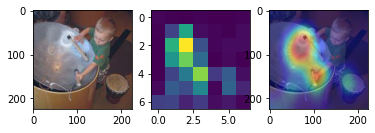

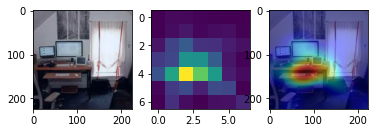

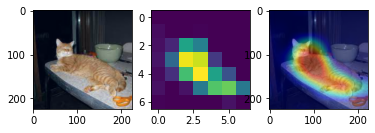

In [164]:
model = resnet50(weights=weights)
model.eval()
gradcam = GradCAM(model)

for i in range(5):

  original_image, interpolated_image = gradcam.interpolate_image(images[i], 'jet')
  gradcam_image = gradcam.get_gradcam(images[i])
    
  plt.subplot(1, 3, 1)
  plt.imshow(original_image)

  plt.subplot(1, 3, 2)
  plt.imshow(gradcam_image)

  plt.subplot(1, 3, 3)
  plt.imshow(interpolated_image)

  plt.show()

## Guided Grad-CAM

In [165]:
class GuidedGradCAM:

  def __init__(self, model):

    self.model = model

  def get_image(self, image):

    guided_backprop = GuidedBackpropagation(self.model)
    gradcam = GradCAM(self.model)

    # Obtain the guided backpropagation and Grad-CAM visualizations of the input image
    guided_backprop_image = guided_backprop.backward_pass(image)
    guided_backprop_image = np.array(guided_backprop_image.detach())
    guided_backprop_image = np.squeeze(guided_backprop_image)

    gradcam_image = gradcam.get_gradcam(image)
    gradcam_image = Image.fromarray(gradcam_image).resize((224, 224), Image.ANTIALIAS)
    gradcam_image = gradcam.normalize_image(gradcam_image)
    gradcam_image = np.array(gradcam_image, dtype=np.uint8)
    gradcam_image = np.expand_dims(gradcam_image, 0)

    # Guided Grad-CAM is the Hadamard product of the above two
    guided_gradcam = np.multiply(guided_backprop_image, gradcam_image)
    guided_gradcam = self.normalize_image(guided_gradcam)
    guided_gradcam = np.transpose(guided_gradcam, (1, 2, 0))
    return guided_gradcam

  def normalize_image(self, image):

    im = np.copy(image)
    im -= np.min(im)
    im /= np.max(im)
    im *= 255
    im = im.astype(np.uint8)
    
    return im

  def process_image(self, grads):

    # Convert gradients to numpy arrays and switch dimensions
    grads = np.array(grads)
    grads = np.squeeze(grads)
    grads = np.transpose(grads, (1, 2, 0))

    # Normalize the gradients
    grads = self.normalize_image(grads)

    return grads

### Visualization of the images

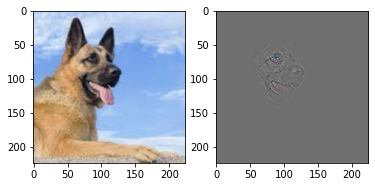

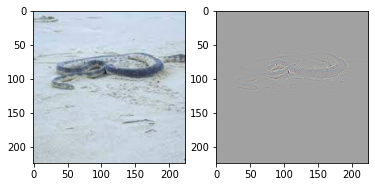

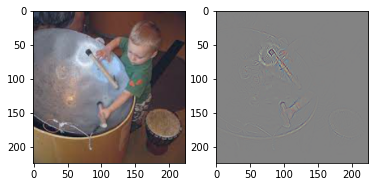

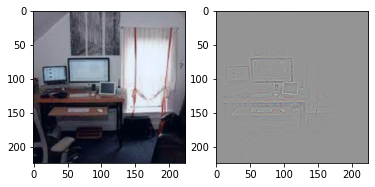

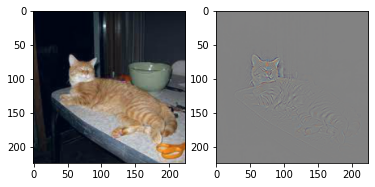

In [166]:
model = resnet50(weights=weights)
model.eval()
guided_gradcam = GuidedGradCAM(model)

for i in range(5):
    
  plt.subplot(1, 2, 1)
  original_image = guided_gradcam.process_image(images[i].detach())
  plt.imshow(original_image)

  plt.subplot(1, 2, 2)
  visualized_image = guided_gradcam.get_image(images[i])
  plt.imshow(visualized_image)

  plt.show()

## Problem 2: SGD Update Rule Variations

In [167]:
# Definition of the objective function
def f(x, y):
  return 10 * x ** 2 + y ** 2

# Gradient of the objective function
def gradient(x, y):
  return np.array([20 * x, 2 * y])

In [168]:
ITERATIONS = 50
START_POINT = np.array([10.0, 15.0])

Text(0.5, 1.0, 'Convergence Visualization')

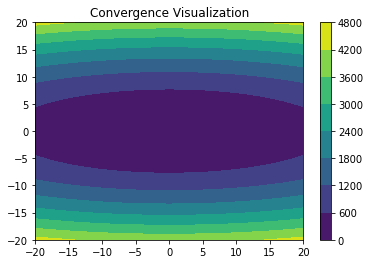

In [169]:
X = np.linspace(-20, 20, 100)
Y = np.linspace(-20, 20, 100)
Z = [[f(x, y) for y in Y] for x in X]

# Plotting
fig, ax = plt.subplots(1, 1)
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Convergence Visualization')

### Vanilla SGD

In [170]:
class VanillaSGD:

  def __init__(self, lr, iters):

    # Learning rate
    self.lr = lr 

    # Number of iterations
    self.iters = iters 

    # List of values at each iteration
    self.values = [] 

  def optimize(self, gradient, start):

    minima = np.copy(start)
    self.values.append(np.copy(minima))

    # Find the minima by an iterative process
    for _ in range(self.iters):
      minima -= self.lr * gradient(minima[0], minima[1])
      self.values.append(np.copy(minima))

    return minima

  def clear(self):

    # Clear the list of values accumulated after the optimization process
    self.values = []

In [171]:
sgd = VanillaSGD(0.05, ITERATIONS)
sgd.optimize(gradient, np.copy(START_POINT))

array([0.        , 0.07730663])

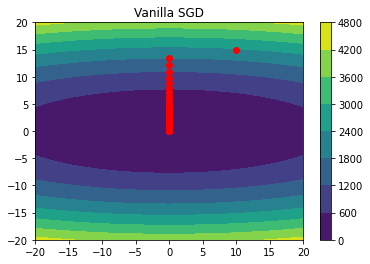

In [172]:
fig1, ax1 = plt.subplots(1, 1)
ax1.set_xlim([-20, 20])
ax1.set_ylim([-20, 20])
cp1 = ax1.contourf(X, Y, Z)
fig.colorbar(cp1)
ax1.set_title('Vanilla SGD')

for value in sgd.values:
  ax1.scatter(value[0], value[1], c='red')

### SGD with Momentum

In [173]:
class SGDMomentum:

  def __init__(self, lr, friction, iters):

    # Learning rate and friction
    self.lr = lr 
    self.friction = friction

    # Number of iterations
    self.iters = iters 

    # List of values at each iteration
    self.values = [] 

  def optimize(self, gradient, start):

    minima = np.copy(start)
    self.values.append(np.copy(minima))
    velocity = 0.0

    # Find the minima by an iterative process
    for _ in range(self.iters):
      velocity = self.friction * velocity + gradient(minima[0], minima[1])
      minima -= self.lr * velocity
      self.values.append(np.copy(minima))

    return minima

  def clear(self):

    # Clear the list of values accumulated after the optimization process
    self.values = []

In [174]:
sgd_momentum = SGDMomentum(0.02, 0.8, ITERATIONS)
sgd_momentum.optimize(gradient, np.copy(START_POINT))

array([-0.0271933, -0.039594 ])

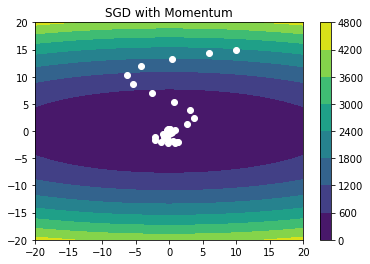

In [175]:
fig2, ax2 = plt.subplots(1, 1)
ax2.set_xlim([-20, 20])
ax2.set_ylim([-20, 20])
cp2 = ax2.contourf(X, Y, Z)
fig.colorbar(cp2)
ax2.set_title('SGD with Momentum')

for value in sgd_momentum.values:
  ax2.scatter(value[0], value[1], c='white')

### Nesterov Momentum

In [176]:
class NesterovMomentum:

  def __init__(self, lr, friction, iters):

    # Learning rate and friction
    self.lr = lr 
    self.friction = friction

    # Number of iterations
    self.iters = iters 

    # List of values at each iteration
    self.values = [] 

  def optimize(self, gradient, start):

    minima = np.copy(start)
    self.values.append(np.copy(minima))
    velocity = 0.0

    # Find the minima by an iterative process
    for _ in range(self.iters):
      next = minima + self.friction * velocity
      velocity = self.friction * velocity + self.lr * gradient(next[0], next[1])
      minima -= velocity
      self.values.append(np.copy(minima))

    return minima

  def clear(self):

    # Clear the list of values accumulated after the optimization process
    self.values = []

In [177]:
nesterov = NesterovMomentum(0.02, 0.6, ITERATIONS)
nesterov.optimize(gradient, np.copy(START_POINT))

array([-0.07162102,  0.00830257])

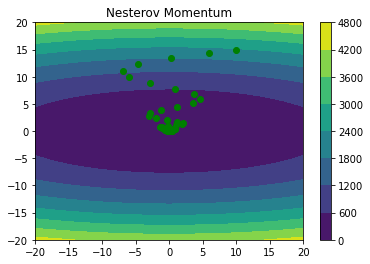

In [178]:
fig3, ax3 = plt.subplots(1, 1)
ax3.set_xlim([-20, 20])
ax3.set_ylim([-20, 20])
cp3 = ax3.contourf(X, Y, Z)
fig.colorbar(cp3)
ax3.set_title('Nesterov Momentum')

for value in nesterov.values:
  ax3.scatter(value[0], value[1], c='green')

### AdaGrad

In [179]:
class AdaGrad:

  def __init__(self, lr, epsilon, iters):

    # Learning rate and epsilon
    self.lr = lr 
    self.epsilon = epsilon

    # Number of iterations
    self.iters = iters 

    # List of values at each iteration
    self.values = [] 

  def optimize(self, gradient, start):

    minima = np.copy(start)
    self.values.append(np.copy(minima))
    grad_sq = 0.0

    # Find the minima by an iterative process
    for _ in range(self.iters):
      grad = gradient(minima[0], minima[1])
      grad_sq += grad ** 2
      minima -= self.lr * grad / (np.sqrt(grad_sq) + self.epsilon)
      self.values.append(np.copy(minima))

    return minima

  def clear(self):

    # Clear the list of values accumulated after the optimization process
    self.values = []

In [180]:
# High learning rate was chosen to make it converge within 50 iterations
# Otherwise, the number of iterations has to be increased
adagrad = AdaGrad(3, 1e-5, ITERATIONS)
adagrad.optimize(gradient, np.copy(START_POINT))

array([9.87761347e-05, 4.26452071e-02])

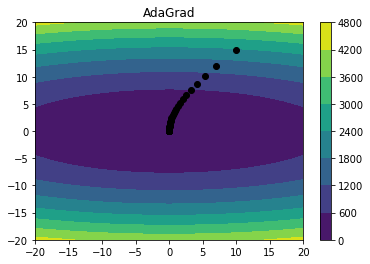

In [181]:
fig4, ax4 = plt.subplots(1, 1)
ax4.set_xlim([-20, 20])
ax4.set_ylim([-20, 20])
cp4 = ax4.contourf(X, Y, Z)
fig.colorbar(cp4)
ax4.set_title('AdaGrad')

for value in adagrad.values:
  ax4.scatter(value[0], value[1], c='black')

### RMSProp

In [182]:
class RMSProp:

  def __init__(self, lr, epsilon, friction, iters):

    # Learning rate, epsilon and friction
    self.lr = lr 
    self.epsilon = epsilon
    self.friction = friction

    # Number of iterations
    self.iters = iters 

    # List of values at each iteration
    self.values = [] 

  def optimize(self, gradient, start):

    minima = np.copy(start)
    self.values.append(np.copy(minima))
    grad_sq = 0.0

    # Find the minima by an iterative process
    for _ in range(self.iters):
      grad = gradient(minima[0], minima[1])
      grad_sq = self.friction * grad_sq + (1 - self.friction) * grad ** 2
      minima -= self.lr * grad / (np.sqrt(grad_sq) + self.epsilon)
      self.values.append(np.copy(minima))

    return minima

  def clear(self):

    # Clear the list of values accumulated after the optimization process
    self.values = []

In [183]:
rmsprop = RMSProp(0.5, 1e-5, 0.9, ITERATIONS)
rmsprop.optimize(gradient, np.copy(START_POINT))

array([1.85561805e-08, 1.26483731e-02])

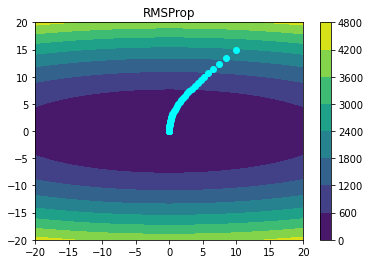

In [184]:
fig5, ax5 = plt.subplots(1, 1)
ax5.set_xlim([-20, 20])
ax5.set_ylim([-20, 20])
cp5 = ax5.contourf(X, Y, Z)
fig.colorbar(cp5)
ax5.set_title('RMSProp')

for value in rmsprop.values:
  ax5.scatter(value[0], value[1], c='cyan')

### Convergence visualization

In [185]:
import matplotlib.animation as animation

def animate(i):
  if i == 0:
    ax.legend()
  ax.scatter(sgd.values[i][0], sgd.values[i][1], c='red', label='SGD')
  ax.scatter(sgd_momentum.values[i][0], sgd_momentum.values[i][1], c='white', label='SGD+M')
  ax.scatter(nesterov.values[i][0], nesterov.values[i][1], c='green', label='Nesterov')
  ax.scatter(adagrad.values[i][0], adagrad.values[i][1], c='black', label='AdaGrad')
  ax.scatter(rmsprop.values[i][0], rmsprop.values[i][1], c='cyan', label='RMSProp')
  return ax,

ani = animation.FuncAnimation(fig, animate, repeat=True, frames=ITERATIONS, interval=50)
writer = animation.PillowWriter(fps=15, bitrate=1800)
ani.save('AI21BTECH11004_convergence.gif', writer=writer)

The GIF is saved as the file `AI21BTECH11004_convergence.gif` in the same directory as the one where the notebook is present